<a href="https://colab.research.google.com/github/sarashahin/Badger_AI/blob/main/Badger_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'project-ai:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4881695%2F8522226%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240527%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240527T152232Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D70402f20d068d00d748df89ed00aecfd994ac167cfcc3b2bb1a299e3e8d2f77b819d6c88afdcd65ad87f26191af1f6f0800c52b01b1f02d4bae05c85e5a89e2d82feafd37f0ebc26c5e3c0ea9139b77b96f3d525d155b531172ec9240cfd3cdc74a77f14d0e76c7ef452a99c45172dd0237c997e08b1bbc710c72eb02f86e21fcb6ff0cccb71e950eabb9ed55fc341b3ccf36033d5ab99d2186382e42dc15779bf50147a980aa65cd9f7da2ad9073f1e9488caae8ec71e2fa50b2f94628ae3c6f9c2ab34d1834ce6634fc575e5649835839d4ef8fd90cb3de3c63ec0058bbe928976ffcb7ba8e511fae62c9da883a02dd2350c0beb751e56465101bdab364c31'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn


import torch.hub
import yaml
import os
import shutil
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
import torch
import xml.etree.ElementTree as ET
from collections import Counter
import numpy as np
from tqdm import tqdm


from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder



In [ ]:


# Paths to the actual image and label
images_path = '/kaggle/input/project-ai/extracted_frames/extracted_frames/'
labels_path = '/kaggle/input/project-ai/Annotation2/Annotation2/'

# files for images and labels
images = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
labels = [f for f in os.listdir(labels_path) if f.endswith('.xml')]

image_names = [os.path.splitext(f)[0] for f in images]
label_names = [os.path.splitext(f)[0] for f in labels]

# Check common names
common_names = list(set(image_names).intersection(set(label_names)))
print(f"Common names count: {len(common_names)}")

# Parse annotations to get class counts
class_counts = Counter()
annotations = {}

for label_file in labels:
    tree = ET.parse(os.path.join(labels_path, label_file))
    root = tree.getroot()
    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        class_counts[cls_name] += 1
        if cls_name not in annotations:
            annotations[cls_name] = []
        annotations[cls_name].append(label_file)

print("Class Counts:", class_counts)




Common names count: 763
Class Counts: Counter({'Badger_3_Fur_Brown': 299, 'Badger_6_Fur_GreyBrown': 293, 'Badger_4_Fur_Grey': 147, 'Badger_10_Ear_Round': 106, 'Badger_12_Fur_GreyBrown': 81, 'Badger_13_Face_Thin': 77, 'Badger_5_Fur_Grey': 72, 'Badger_7_Tail_LongBrown': 60, 'Badger_8_Ear_Notche': 55, 'Badger_9_Face_LongStripe': 40, 'Badger_14_Ear_Small': 38, 'Badger_11_Tail_Wide': 17, 'Badger_1_Face_Stripe': 16, 'Badger_2_Face_Stripe': 14})


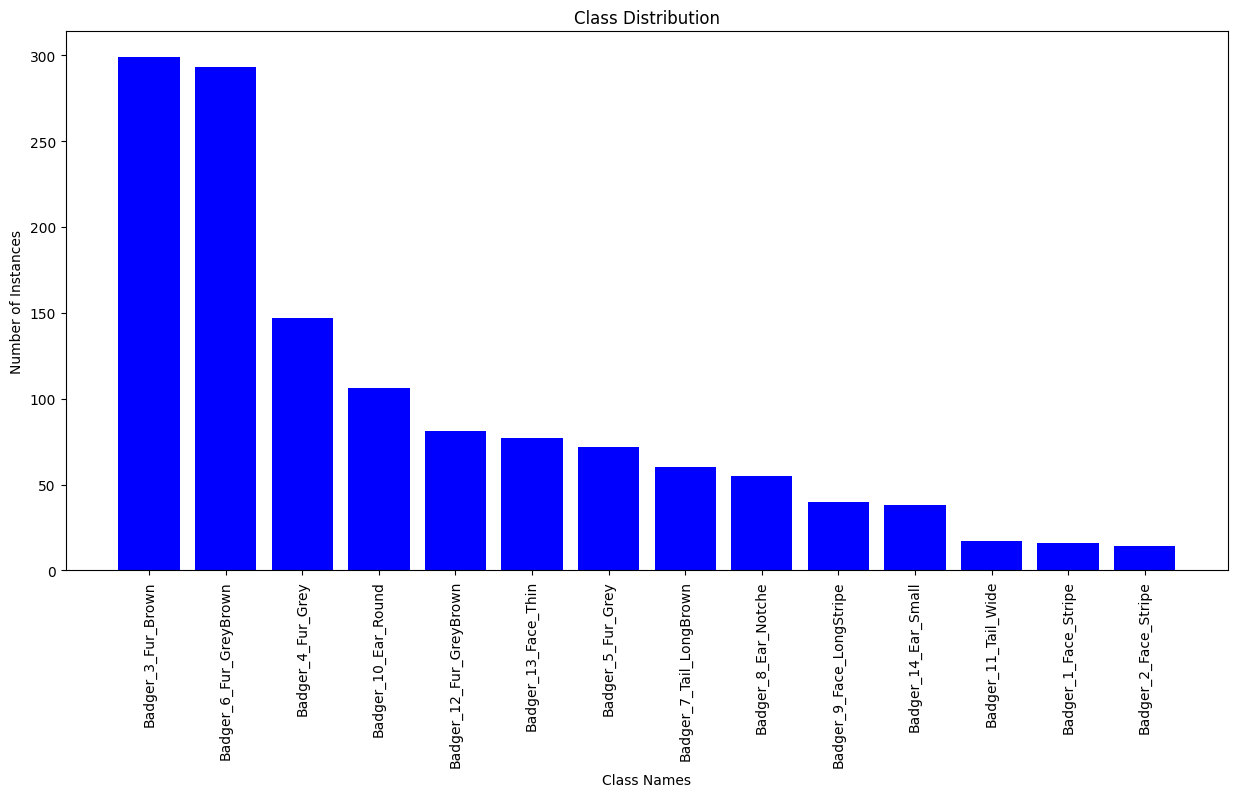

Badger_3_Fur_Brown: 299
Badger_6_Fur_GreyBrown: 293
Badger_4_Fur_Grey: 147
Badger_10_Ear_Round: 106
Badger_12_Fur_GreyBrown: 81
Badger_13_Face_Thin: 77
Badger_5_Fur_Grey: 72
Badger_7_Tail_LongBrown: 60
Badger_8_Ear_Notche: 55
Badger_9_Face_LongStripe: 40
Badger_14_Ear_Small: 38
Badger_11_Tail_Wide: 17
Badger_1_Face_Stripe: 16
Badger_2_Face_Stripe: 14


In [ ]:
# Paths label
labels_path = '/kaggle/input/project-ai/Annotation2/Annotation2/'

# Extracting Unique Classes and Counts
class_counts = {}

# Parse XML files to count instances of each class
for xml_file in os.listdir(labels_path):
    if xml_file.endswith('.xml'):
        tree = ET.parse(os.path.join(labels_path, xml_file))
        root = tree.getroot()
        for obj in root.iter('object'):
            cls_name = obj.find('name').text
            if cls_name in class_counts:
                class_counts[cls_name] += 1
            else:
                class_counts[cls_name] = 1

# Sort classes by count
sorted_classes = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)

# Separate class names and counts for plotting
classes, counts = zip(*sorted_classes)

# Plotting the class distribution
plt.figure(figsize=(15, 7))
plt.bar(classes, counts, color='blue')
plt.xlabel('Class Names')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

# Print class counts for reference
for cls, count in sorted_classes:
    print(f'{cls}: {count}')

In [ ]:
# Extracting Unique Classes

labels_path = '/kaggle/input/project-ai/Annotation2/Annotation2/'
classes = set()

# Parse XML files to extract unique class names
for xml_file in os.listdir(labels_path):
    if xml_file.endswith('.xml'):
        tree = ET.parse(os.path.join(labels_path, xml_file))
        root = tree.getroot()
        for obj in root.iter('object'):
            cls_name = obj.find('name').text
            classes.add(cls_name)

# unique class names to a file
with open('classes.txt', 'w') as f:
    for cls in sorted(classes):
        f.write(f"{cls}\n")

print(f"Found {len(classes)} unique classes.")

Found 14 unique classes.


In [ ]:


# Map class names to indices
with open('classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
threshold = 10
underrepresented_classes = [cls for cls, count in class_counts.items() if count < threshold]

def extract_bboxes(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    labels = []
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        ymin = int(xmlbox.find('ymin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymax = int(xmlbox.find('ymax').text)
        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(cls_name)

    return bboxes, labels, width, height



In [ ]:
# Split data into train/val
from sklearn.model_selection import train_test_split


# train/test split
train_names, val_names = train_test_split(common_names, test_size=0.2, random_state=42)

def copy_files(names, src_images, src_labels, dest_images, dest_labels):
    os.makedirs(dest_images, exist_ok=True)
    os.makedirs(dest_labels, exist_ok=True)
    for name in names:
        shutil.copy(os.path.join(src_images, name + '.jpg'), os.path.join(dest_images, name + '.jpg'))
        shutil.copy(os.path.join(src_labels, name + '.xml'), os.path.join(dest_labels, name + '.xml'))

# Copy files to train/val directories
copy_files(train_names, images_path, labels_path, 'dataset/images/train', 'dataset/labels/train')
copy_files(val_names, images_path, labels_path, 'dataset/images/val', 'dataset/labels/val')

In [ ]:
import torch

# Calculate class weights
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
max_weight = max(class_weights.values())
class_weights = {cls: weight / max_weight for cls, weight in class_weights.items()}

print("Class Weights:", class_weights)

# Convert class weights to tensor
class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts)], dtype=torch.float32)

print("Class Weights Tensor:", class_weights_tensor)


Class Weights: {'Badger_11_Tail_Wide': 0.823529411764706, 'Badger_3_Fur_Brown': 0.04682274247491639, 'Badger_4_Fur_Grey': 0.09523809523809523, 'Badger_6_Fur_GreyBrown': 0.0477815699658703, 'Badger_10_Ear_Round': 0.1320754716981132, 'Badger_8_Ear_Notche': 0.2545454545454546, 'Badger_9_Face_LongStripe': 0.35, 'Badger_7_Tail_LongBrown': 0.23333333333333334, 'Badger_13_Face_Thin': 0.18181818181818182, 'Badger_12_Fur_GreyBrown': 0.1728395061728395, 'Badger_14_Ear_Small': 0.368421052631579, 'Badger_5_Fur_Grey': 0.19444444444444445, 'Badger_1_Face_Stripe': 0.875, 'Badger_2_Face_Stripe': 1.0}
Class Weights Tensor: tensor([0.1321, 0.8235, 0.1728, 0.1818, 0.3684, 0.8750, 1.0000, 0.0468, 0.0952,
        0.1944, 0.0478, 0.2333, 0.2545, 0.3500])


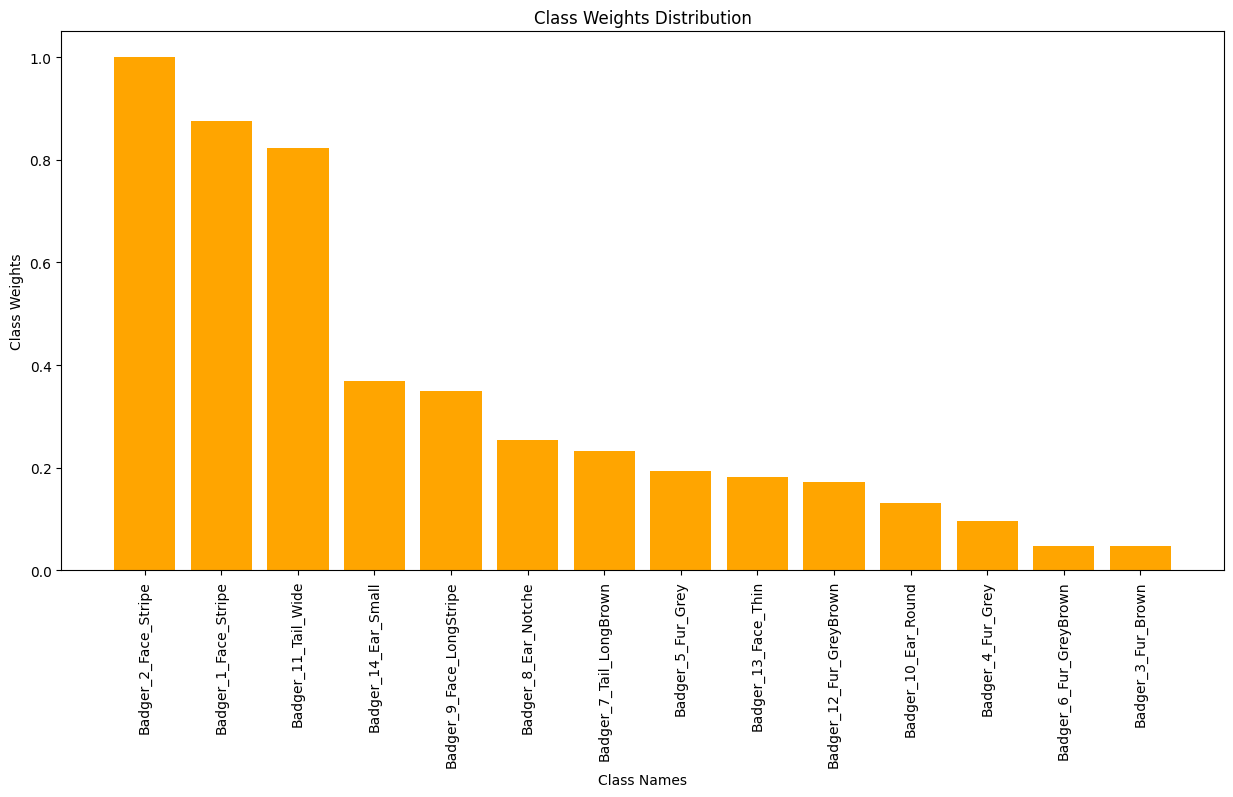

Badger_2_Face_Stripe: 14
Badger_1_Face_Stripe: 16
Badger_11_Tail_Wide: 17
Badger_14_Ear_Small: 38
Badger_9_Face_LongStripe: 40
Badger_8_Ear_Notche: 55
Badger_7_Tail_LongBrown: 60
Badger_5_Fur_Grey: 72
Badger_13_Face_Thin: 77
Badger_12_Fur_GreyBrown: 81
Badger_10_Ear_Round: 106
Badger_4_Fur_Grey: 147
Badger_6_Fur_GreyBrown: 293
Badger_3_Fur_Brown: 299


In [ ]:
# Visualization of Class Weights
sorted_classes = sorted(class_weights.items(), key=lambda item: item[1], reverse=True)
classes, weights = zip(*sorted_classes)

plt.figure(figsize=(15, 7))
plt.bar(classes, weights, color='orange')
plt.xlabel('Class Names')
plt.ylabel('Class Weights')
plt.title('Class Weights Distribution')
plt.xticks(rotation=90)
plt.show()


# Print class counts
for cls in classes:
    print(f'{cls}: {class_counts[cls]}')

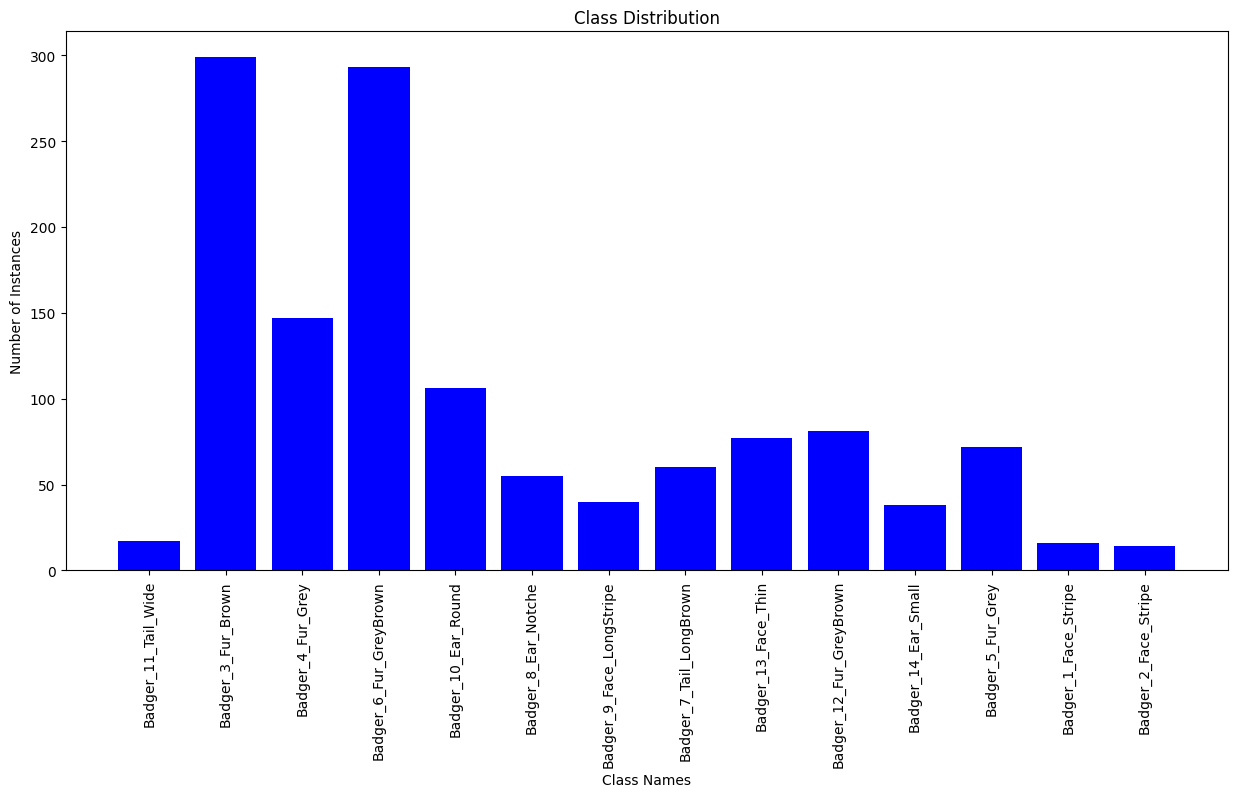

In [ ]:

import matplotlib.pyplot as plt

# Visualize class distribution
plt.figure(figsize=(15, 7))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xlabel('Class Names')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()


In [ ]:

# YAML Configuration File
# Load the unique classes from the file
with open('classes.txt') as f:
    unique_classes = [line.strip() for line in f.readlines()]

# Create the badger.yaml configuration file
yaml_content = f"""
train: /kaggle/working/dataset/images/train
val: /kaggle/working/dataset/images/val

nc: {len(unique_classes)}  # number of classes
names: {unique_classes}
"""

with open('/kaggle/working/badger.yaml', 'w') as file:
    file.write(yaml_content)

In [ ]:

# Initial hyperparameters settings


# hyperparameters including augmentation fields
initial_hyp = {
    'lr0': 0.001,  # initial learning rate
    'lrf': 0.01,   # final OneCycleLR learning rate
    'momentum': 0.937,  # SGD momentum
    'weight_decay': 0.0005,  # optimizer weight decay
    'warmup_epochs': 3.0,  # warmup epochs
    'warmup_momentum': 0.8,  # warmup initial momentum
    'warmup_bias_lr': 0.1,  # warmup initial bias lr
    'box': 0.05,  # box loss gain
    'cls': 0.5,  # cls loss gain
    'cls_pw': 1.0,  # cls BCELoss positive_weight
    'obj': 1.0,  # obj loss gain
    'obj_pw': 1.0,  # obj BCELoss positive_weight
    'iou_t': 0.20,  # IoU training threshold
    'anchor_t': 3.0,  # anchor-multiple threshold
    'fl_gamma': 0.0,  # focal loss gamma
    'mosaic': 0.0,  # probability of mosaic augmentation
    'mixup': 0.0,  # probability mixup augmentation
    'degrees': 0.0,  # maximum rotation for augmentation
    'translate': 0.0,  # translate ratio for augmentation
    'scale': 0.0,  # scale ratio for augmentation
    'shear': 0.0,  # shear ratio for augmentation
    'perspective': 0.0,  # perspective ratio for augmentation
    'flipud': 0.0,  # probability of flipping image upside down
    'fliplr': 0.0,  # probability of flipping image left to right
    'copy_paste' : 0.0,
    'hsv_h': 0.015,  # hue adjust in HSV space
    'hsv_s': 0.2,  # saturation adjust in HSV space
    'hsv_v': 0.2,  # value adjust in HSV space
     # Add class weights
    'class_weights': [class_weights[cls] for cls in sorted(class_counts)],
    'dropout': 0.4,  # dropout probability
#     'class_weights': [0.04, 0.04, 0.25, 0.05263157894736842, 0.041666666666666664, 0.049999999999999996, 0.04761904761904762, 0.04, 0.125, 0.04761904761904762, 0.04761904761904762, 0.03703703703703704, 0.0625, 0.25, 0.0625, 0.04761904761904762, 0.013513513513513513, 0.125, 0.041666666666666664, 0.19999999999999998, 0.05555555555555555, 0.19999999999999998, 0.022727272727272724, 0.07142857142857142, 0.02857142857142857, 0.07142857142857142, 0.25, 0.19999999999999998, 0.3333333333333333, 1.0, 0.25, 1.0, 0.16666666666666666, 0.1111111111111111, 0.1111111111111111, 1.0, 0.19999999999999998, 0.25, 1.0, 1.0, 1.0, 0.19999999999999998, 0.09999999999999999, 0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.08333333333333333, 0.3333333333333333, 1.0, 0.023255813953488375, 0.02631578947368421, 0.5, 0.06666666666666667, 1.0, 1.0, 0.19999999999999998, 0.1111111111111111, 1.0, 0.07692307692307693, 1.0, 0.04545454545454545, 0.017543859649122806, 0.05263157894736842, 0.038461538461538464, 0.012499999999999999, 0.024999999999999998, 0.02380952380952381, 0.1111111111111111, 0.06666666666666667, 0.01851851851851852, 0.023255813953488375, 0.5, 0.25, 0.01075268817204301, 0.027777777777777776, 0.018181818181818184, 0.03571428571428571, 0.007874015748031496, 0.03571428571428571, 0.0625, 0.19999999999999998, 0.25, 0.07692307692307693, 0.5, 0.1111111111111111, 0.012499999999999999, 0.25, 0.03571428571428571, 0.25, 0.125, 0.0909090909090909, 0.3333333333333333, 0.07692307692307693, 0.25, 0.0909090909090909, 0.029411764705882353, 0.125, 1.0, 0.013513513513513513, 0.14285714285714285, 0.09999999999999999, 0.05555555555555555, 0.03125, 0.0625]
}

#hyperparameters to 'hyp.yaml'
with open('/kaggle/working/hyp.yaml', 'w') as f:
    yaml.dump(initial_hyp, f)

# Verify the creation
print("Initial hyperparameters set in 'hyp.yaml':")
with open('/kaggle/working/hyp.yaml') as f:
    print(f.read())


Initial hyperparameters set in 'hyp.yaml':
anchor_t: 3.0
box: 0.05
class_weights:
- 0.1320754716981132
- 0.823529411764706
- 0.1728395061728395
- 0.18181818181818182
- 0.368421052631579
- 0.875
- 1.0
- 0.04682274247491639
- 0.09523809523809523
- 0.19444444444444445
- 0.0477815699658703
- 0.23333333333333334
- 0.2545454545454546
- 0.35
cls: 0.5
cls_pw: 1.0
copy_paste: 0.0
degrees: 0.0
dropout: 0.4
fl_gamma: 0.0
fliplr: 0.0
flipud: 0.0
hsv_h: 0.015
hsv_s: 0.2
hsv_v: 0.2
iou_t: 0.2
lr0: 0.001
lrf: 0.01
mixup: 0.0
momentum: 0.937
mosaic: 0.0
obj: 1.0
obj_pw: 1.0
perspective: 0.0
scale: 0.0
shear: 0.0
translate: 0.0
warmup_bias_lr: 0.1
warmup_epochs: 3.0
warmup_momentum: 0.8
weight_decay: 0.0005



In [ ]:
# After updating hyp.yaml
with open('/kaggle/working/hyp.yaml', 'r') as f:
    updated_hyp = yaml.safe_load(f)
print("Updated hyperparameters:", updated_hyp)


Updated hyperparameters: {'anchor_t': 3.0, 'box': 0.05, 'class_weights': [0.1320754716981132, 0.823529411764706, 0.1728395061728395, 0.18181818181818182, 0.368421052631579, 0.875, 1.0, 0.04682274247491639, 0.09523809523809523, 0.19444444444444445, 0.0477815699658703, 0.23333333333333334, 0.2545454545454546, 0.35], 'cls': 0.5, 'cls_pw': 1.0, 'copy_paste': 0.0, 'degrees': 0.0, 'dropout': 0.4, 'fl_gamma': 0.0, 'fliplr': 0.0, 'flipud': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.2, 'hsv_v': 0.2, 'iou_t': 0.2, 'lr0': 0.001, 'lrf': 0.01, 'mixup': 0.0, 'momentum': 0.937, 'mosaic': 0.0, 'obj': 1.0, 'obj_pw': 1.0, 'perspective': 0.0, 'scale': 0.0, 'shear': 0.0, 'translate': 0.0, 'warmup_bias_lr': 0.1, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'weight_decay': 0.0005}


In [ ]:

# Load the unique classes from the file
with open('classes.txt') as f:
    unique_classes = [line.strip() for line in f.readlines()]

# Generate YAML, class names
yaml_content = f"""
nc: {len(unique_classes)}  # number of classes
names: [{', '.join(f"'{name}'" for name in unique_classes)}]
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# Anchors
anchors:
  - [10, 13, 16, 30, 33, 23]

# Backbone
backbone:
  - [-1, 1, 'Focus', [64, 3]]
  - [-1, 1, 'Conv', [128, 3, 2]]
  - [-1, 3, 'C3', [128]]
  - [-1, 1, 'Conv', [256, 3, 2]]
  - [-1, 9, 'C3', [256]]
  - [-1, 1, 'Conv', [512, 3, 2]]
  - [-1, 9, 'C3', [512]]
  - [-1, 1, 'Conv', [1024, 3, 2]]
  - [-1, 1, 'SPP', [1024, [5, 9, 13]]]
  - [-1, 3, 'C3', [1024, False]]

# Head
head:
  - [-1, 1, 'Conv', [512, 1, 1]]
  - [-1, 1, 'nn.Upsample', [None, 2, 'nearest']]
  - [[-1, 6], 1, 'Concat', [1]]
  - [-1, 3, 'C3', [512, False]]
  - [-1, 1, 'Conv', [256, 1, 1]]
  - [-1, 1, 'nn.Upsample', [None, 2, 'nearest']]
  - [[-1, 4], 1, 'Concat', [1]]
  - [-1, 3, 'C3', [256, False]]
  - [-1, 1, 'Conv', [256, 3, 2]]
  - [[-1, 14], 1, 'Concat', [1]]
  - [-1, 3, 'C3', [512, False]]
  - [-1, 1, 'Conv', [512, 3, 2]]
  - [[-1, 10], 1, 'Concat', [1]]
  - [-1, 3, 'C3', [1024, False]]
  - [-1, 1, 'Detect', [nc, anchors]]
"""

# Write the YAML content to a file
yaml_file_path = '/kaggle/working/custom_yolov5s.yaml'
with open(yaml_file_path, 'w') as file:
    file.write(yaml_content)
print(f"YAML configuration saved to {yaml_file_path}")

# Validate the YAML
with open(yaml_file_path, 'r') as file:
    try:
        yaml_data = yaml.safe_load(file)
        print("YAML is valid.")
        print(yaml_data)
    except yaml.YAMLError as exc:
        print("Error in YAML file:", exc)


YAML configuration saved to /kaggle/working/custom_yolov5s.yaml
YAML is valid.
{'nc': 14, 'names': ['Badger_10_Ear_Round', 'Badger_11_Tail_Wide', 'Badger_12_Fur_GreyBrown', 'Badger_13_Face_Thin', 'Badger_14_Ear_Small', 'Badger_1_Face_Stripe', 'Badger_2_Face_Stripe', 'Badger_3_Fur_Brown', 'Badger_4_Fur_Grey', 'Badger_5_Fur_Grey', 'Badger_6_Fur_GreyBrown', 'Badger_7_Tail_LongBrown', 'Badger_8_Ear_Notche', 'Badger_9_Face_LongStripe'], 'depth_multiple': 0.33, 'width_multiple': 0.5, 'anchors': [[10, 13, 16, 30, 33, 23]], 'backbone': [[-1, 1, 'Focus', [64, 3]], [-1, 1, 'Conv', [128, 3, 2]], [-1, 3, 'C3', [128]], [-1, 1, 'Conv', [256, 3, 2]], [-1, 9, 'C3', [256]], [-1, 1, 'Conv', [512, 3, 2]], [-1, 9, 'C3', [512]], [-1, 1, 'Conv', [1024, 3, 2]], [-1, 1, 'SPP', [1024, [5, 9, 13]]], [-1, 3, 'C3', [1024, False]]], 'head': [[-1, 1, 'Conv', [512, 1, 1]], [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 6], 1, 'Concat', [1]], [-1, 3, 'C3', [512, False]], [-1, 1, 'Conv', [256, 1, 1]], [-1, 1, '

In [ ]:
# Converting Annotations
# Load class names
with open('classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# Map class names to indices
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
def convert(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

def is_within_bounds(box, width, height):
    xmin, xmax, ymin, ymax = box
    if xmin < 0 or xmax > width or ymin < 0 or ymax > height:
        return False
    if xmax <= xmin or ymax <= ymin:
        return False
    return True

def convert_annotation(xml_file, txt_file):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        with open(txt_file, 'w') as out_file:
            for obj in root.iter('object'):
                cls_name = obj.find('name').text
                if cls_name in class_to_idx:
                    cls_id = class_to_idx[cls_name]
                    xmlbox = obj.find('bndbox')
                    b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                         float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
                    if not is_within_bounds(b, w, h):
                        print(f"Warning: Box {b} in file {xml_file} is out of bounds.")
                        continue
                    bb = convert((w, h), b)
                    out_file.write(f"{cls_id} {' '.join(map(str, bb))}\n")
    except Exception as e:
        print(f"Error processing file {xml_file}: {e}")

# Convert annotations for both train and val sets
for phase in ['train', 'val']:
    xml_dir = f'/kaggle/working/dataset/labels/{phase}'
    txt_dir = f'/kaggle/working/dataset/labels_yolo/{phase}'
    os.makedirs(txt_dir, exist_ok=True)
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith('.xml'):
            convert_annotation(os.path.join(xml_dir, xml_file), os.path.join(txt_dir, xml_file.replace('.xml', '.txt')))


In [ ]:
# Checking Labels

def check_labels(path, num_files=5):
    from os import listdir
    from os.path import isfile, join
    files = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('.txt')]
    for f in files[:num_files]:
        print(f'Contents of {f}:')
        with open(join(path, f), 'r') as file:
            contents = file.read()
            print(contents)
            if contents.strip() == '':
                print("Warning: Empty label file!")

check_labels('/kaggle/working/dataset/labels_yolo/train/')

Contents of IMG_0003_frame_4980.txt:
0 0.5963541666666666 0.39722222222222225 0.029166666666666667 0.044444444444444446
0 0.6208333333333333 0.3578703703703704 0.025 0.028703703703703703

Contents of IMG_0081_frame_0.txt:
12 0.5543750000000001 0.48783185840707965 0.0375 0.05530973451327434
12 0.503125 0.4811946902654867 0.0375 0.05530973451327434

Contents of mum_with_cub_frame_2520.txt:
7 0.4731770833333333 0.22083333333333335 0.18489583333333334 0.3101851851851852
8 0.28463541666666664 0.23703703703703705 0.12864583333333332 0.22777777777777777

Contents of IMG_0004_frame_1080.txt:
1 0.4635416666666667 0.48333333333333334 0.034375 0.06851851851851852

Contents of dominate_female_with_cubs_frame_1980.txt:
7 0.9533854166666667 0.3787037037037037 0.09322916666666667 0.2962962962962963
8 0.8158854166666667 0.44027777777777777 0.13489583333333333 0.18425925925925926



In [ ]:
# Re-link Labels and Re-run Training

os.makedirs('/kaggle/working/dataset/labels/train', exist_ok=True)
os.makedirs('/kaggle/working/dataset/labels/val', exist_ok=True)

# Create symbolic links
!ln -sfn /kaggle/working/dataset/labels_yolo/train/* /kaggle/working/dataset/labels/train/
!ln -sfn /kaggle/working/dataset/labels_yolo/val/* /kaggle/working/dataset/labels/val/


# Verify symbolic links
print("Train labels:", os.listdir('/kaggle/working/dataset/labels/train')[:10])
print("Val labels:", os.listdir('/kaggle/working/dataset/labels/val')[:10])

Train labels: ['IMG_0015_frame_2580.xml', 'IMG_0079_frame_720.xml', 'dominate_female_with_cubs_frame_540.xml', 'IMG_0003_frame_3420.xml', 'IMG_0003_frame_4980.txt', '3 badgers feeding 5_frame_240.xml', 'IMG_0081_frame_0.txt', 'mum_with_cub_frame_3240.xml', 'IMG_0003 (2)_frame_720.xml', 'mum_with_cub_frame_2520.txt']
Val labels: ['IMG_0082_frame_720.xml', 'dominate_female_with_cubs_frame_2340.txt', 'IMG_0045_frame_120.xml', 'bum_pressing_1_frame_300.xml', 'CUBS_CALLING_UNDERGROUND_frame_960.txt', 'CUBS_CALLING_UNDERGROUND_frame_840.txt', 'IMG_0086_frame_120.txt', 'IMG_0003_frame_1560.txt', 'roley-poley_frame_300.txt', 'bum_pressing_1_frame_780.xml']


In [ ]:
# Install YOLOv5 dependencies
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.9.3 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-automl 1.0.1 requires google-api-core[grpc]<2.0.0dev,>=1

In [ ]:

# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16625, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 16625 (delta 58), reused 66 (delta 30), pack-reused 16522
Receiving objects: 100% (16625/16625), 15.16 MiB | 33.18 MiB/s, done.
Resolving deltas: 100% (11415/11415), done.


In [ ]:
# current working directory
%cd /kaggle/working/yolov5

/kaggle/working/yolov5


In [ ]:
# List of the yolov5
!ls models

__init__.py  experimental.py  segment  yolo.py	     yolov5m.yaml  yolov5s.yaml
common.py    hub	      tf.py    yolov5l.yaml  yolov5n.yaml  yolov5x.yaml


In [ ]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 10.7 MB/s eta 0:00:0000:01


In [ ]:

def update_and_train(hyp_params, base_command, iteration):
    hyp_path = '/kaggle/working/hyp.yaml'
    with open(hyp_path, 'r') as file:
        hyp = yaml.safe_load(file)
    hyp.update(hyp_params)
    with open(hyp_path, 'w') as file:
        yaml.safe_dump(hyp, file)

    # base command and a unique run name for each iteration
    run_name = f"custom_badger_detection_{iteration}"
    command = f"{base_command} --name {run_name}"
    print(f"Running training with updated hyperparameters: {hyp_params} and run name: {run_name}")
    subprocess.run(command, shell=True)
    return run_name

# Base training command
base_command = "python train.py --img 640 --epochs 50 --data /kaggle/working/badger.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --hyp /kaggle/working/hyp.yaml --save-period 1"

# Define hyperparameter space
learning_rate_options = [0.01, 0.04, 0.06]
batch_size_options = [16, 32]
momentum_options = [0.85, 0.95]

# for random search
num_iterations = 6

# Perform random search and validate each model
for i in range(num_iterations):
    lr = random.choice(learning_rate_options)
    batch_size = random.choice(batch_size_options)
    momentum = random.choice(momentum_options)
    hyp_params = {'lr0': lr, 'batch_size': batch_size, 'momentum' : momentum}
    run_name = update_and_train(hyp_params, base_command, i)

    # Validation for each trained model
    val_command = f"python val.py --data /kaggle/working/badger.yaml --weights runs/train/{run_name}/weights/best.pt --img 640"
    print(f"Running validation for {run_name}")
    subprocess.run(val_command, shell=True)





Running training with updated hyperparameters: {'lr0': 0.01, 'batch_size': 32, 'momentum': 0.95} and run name: custom_badger_detection_0


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-05-27 11:42:38.023101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 11:42:38.023227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 11:42:38.158712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/kaggle/working/badger.yaml, hyp=/kaggle/working/hyp.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False

Running validation for custom_badger_detection_0


val: data=/kaggle/working/badger.yaml, weights=['runs/train/custom_badger_detection_0/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-314-g60dde7f1 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /kaggle/working/dataset/labels/val.cache... 153 images, 0 backgrounds, 0 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
                   all        153        261      0.934      0.813      0.891      0.524
   Badger_10_Ear_Round        153         25      0.946    

Running training with updated hyperparameters: {'lr0': 0.06, 'batch_size': 32, 'momentum': 0.85} and run name: custom_badger_detection_1


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-05-27 11:55:25.061522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 11:55:25.061582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 11:55:25.063390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/kaggle/working/badger.yaml, hyp=/kaggle/working/hyp.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False

Running validation for custom_badger_detection_1


val: data=/kaggle/working/badger.yaml, weights=['runs/train/custom_badger_detection_1/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-314-g60dde7f1 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /kaggle/working/dataset/labels/val.cache... 153 images, 0 backgrounds, 0 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]
                   all        153        261      0.873      0.855      0.896      0.542
   Badger_10_Ear_Round        153         25      0.844    

Running training with updated hyperparameters: {'lr0': 0.06, 'batch_size': 16, 'momentum': 0.85} and run name: custom_badger_detection_2


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-05-27 12:08:00.545257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 12:08:00.545309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 12:08:00.546937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/kaggle/working/badger.yaml, hyp=/kaggle/working/hyp.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False

Running validation for custom_badger_detection_2


val: data=/kaggle/working/badger.yaml, weights=['runs/train/custom_badger_detection_2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-314-g60dde7f1 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /kaggle/working/dataset/labels/val.cache... 153 images, 0 backgrounds, 0 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]
                   all        153        261      0.873      0.855      0.896      0.542
   Badger_10_Ear_Round        153         25      0.844    

Running training with updated hyperparameters: {'lr0': 0.01, 'batch_size': 16, 'momentum': 0.95} and run name: custom_badger_detection_3


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-05-27 12:20:42.360961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 12:20:42.361025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 12:20:42.362551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/kaggle/working/badger.yaml, hyp=/kaggle/working/hyp.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False

Running validation for custom_badger_detection_3


val: data=/kaggle/working/badger.yaml, weights=['runs/train/custom_badger_detection_3/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-314-g60dde7f1 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /kaggle/working/dataset/labels/val.cache... 153 images, 0 backgrounds, 0 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                   all        153        261      0.934      0.813      0.891      0.524
   Badger_10_Ear_Round        153         25      0.946    

Running training with updated hyperparameters: {'lr0': 0.06, 'batch_size': 16, 'momentum': 0.85} and run name: custom_badger_detection_4


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-05-27 12:33:35.496217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 12:33:35.496265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 12:33:35.497828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/kaggle/working/badger.yaml, hyp=/kaggle/working/hyp.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False

Running validation for custom_badger_detection_4


val: data=/kaggle/working/badger.yaml, weights=['runs/train/custom_badger_detection_4/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-314-g60dde7f1 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /kaggle/working/dataset/labels/val.cache... 153 images, 0 backgrounds, 0 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it]
                   all        153        261      0.873      0.855      0.896      0.542
   Badger_10_Ear_Round        153         25      0.844    

Running training with updated hyperparameters: {'lr0': 0.04, 'batch_size': 32, 'momentum': 0.95} and run name: custom_badger_detection_5


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-05-27 12:46:24.047941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 12:46:24.047999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 12:46:24.049704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/kaggle/working/badger.yaml, hyp=/kaggle/working/hyp.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False

Running validation for custom_badger_detection_5


val: data=/kaggle/working/badger.yaml, weights=['runs/train/custom_badger_detection_5/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-314-g60dde7f1 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /kaggle/working/dataset/labels/val.cache... 153 images, 0 backgrounds, 0 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]
                   all        153        261      0.942      0.691      0.818       0.48
   Badger_10_Ear_Round        153         25      0.897    

In [ ]:
# !pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt

results_path = '/kaggle/working/yolov5/runs/train/custom_badger_detection_0/results.csv'
df = pd.read_csv(results_path)

df.columns = df.columns.str.strip()

epochs = df['epoch']
train_box_loss = df['train/obj_loss']
val_box_loss = df['val/obj_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_box_loss, label='Train Object Loss', color='blue')
plt.plot(epochs, val_box_loss, label='Validation Object Loss', color='orange')

plt.title('Training and Validation Object Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Object Loss')

plt.legend()
plt.show()

In [ ]:
# Paths
new_images_path = '/kaggle/input/project-ai/Badger Photos'

# Update YAML file if necessary (manually or programmatically)
model_weights_path = '/kaggle/working/yolov5/runs/train/custom_badger_detection_5/weights/best.pt'

# Run detection
# source path is enclosed in quotes to handle spaces
detect_command = f'python detect.py --weights "{model_weights_path}" --img 640 --conf 0.25 --source "{new_images_path}"'
result = subprocess.run(detect_command, shell=True, capture_output=True, text=True)

# Check if there were errors
if result.returncode == 0:
    print("Detection completed successfully. Check the runs/detect/exp folder for outputs.")
else:
    print("Detection failed. Error output:")
    print(result.stderr)

Detection completed successfully. Check the runs/detect/exp folder for outputs.


In [ ]:
# Path to the detection output folder
output_folder = 'runs/detect/exp5'

# Zip the detection output folder
shutil.make_archive('detection_results', 'zip', output_folder)
print("Detection results have been zipped into detection_results.zip")

Detection results have been zipped into detection_results.zip
